## Import

In [161]:
import pandas as pd
import numpy as np
import pickle
import sklearn
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler # Standard because it is standard, we
# we are not really working with some known boundary and OneHot for categorical.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Read Data

In [162]:
df = pd.read_csv("data/bank_dataset.csv")

In [163]:
df.shape

(41188, 21)

In [164]:
df.head()

,age,occupation,marital_status,education,has_credit,housing_loan,personal_loan,contact_mode,month,week_day,...,contacts_per_campaign,N_last_days,nb_previous_contact,previous_outcome,emp_var_rate,cons_price_index,cons_conf_index,euri_3_month,nb_employees,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Distinguish categorical and continuous variables

In [165]:
cat_var = df.select_dtypes(include=['O']).columns[:-1] # We remove target
cont_var = df.select_dtypes(include=['float64', 'int64']).columns

In [166]:
cat_var

Index(['occupation', 'marital_status', 'education', 'has_credit',
       'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day',
       'previous_outcome'],
      dtype='object')

Check if there are any Nan values.

In [167]:
df[cont_var].isnull().values.sum()

0

# Data visualization

In [168]:
df.columns

Index(['age', 'occupation', 'marital_status', 'education', 'has_credit',
       'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day',
       'last_contact_duration', 'contacts_per_campaign', 'N_last_days',
       'nb_previous_contact', 'previous_outcome', 'emp_var_rate',
       'cons_price_index', 'cons_conf_index', 'euri_3_month', 'nb_employees',
       'target'],
      dtype='object')

/tmp/ipykernel_70393/4050695000.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='Set1').set(title='Countplot of target')


[Text(0.5, 1.0, 'Countplot of target')]

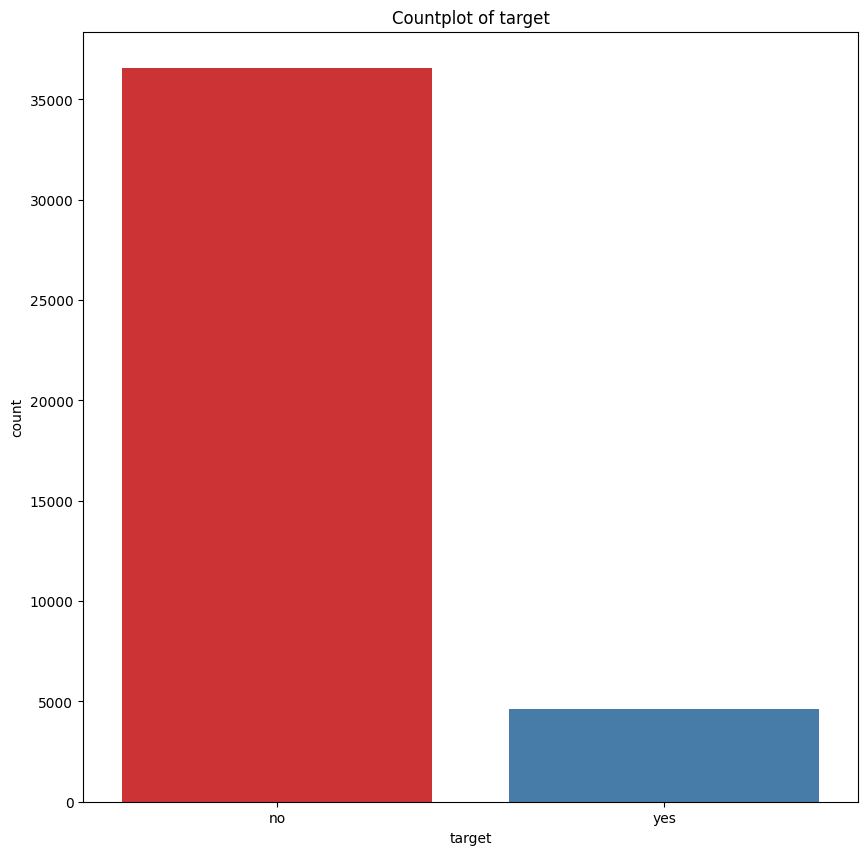

In [169]:
sns.countplot(x='target', data=df, palette='Set1').set(title='Countplot of target')

There's an imbalance within the targets. More people are not inclined in saying "yes" to buy a product from the bank.

[Text(0.5, 1.0, 'Countplot of targets based on marital status')]

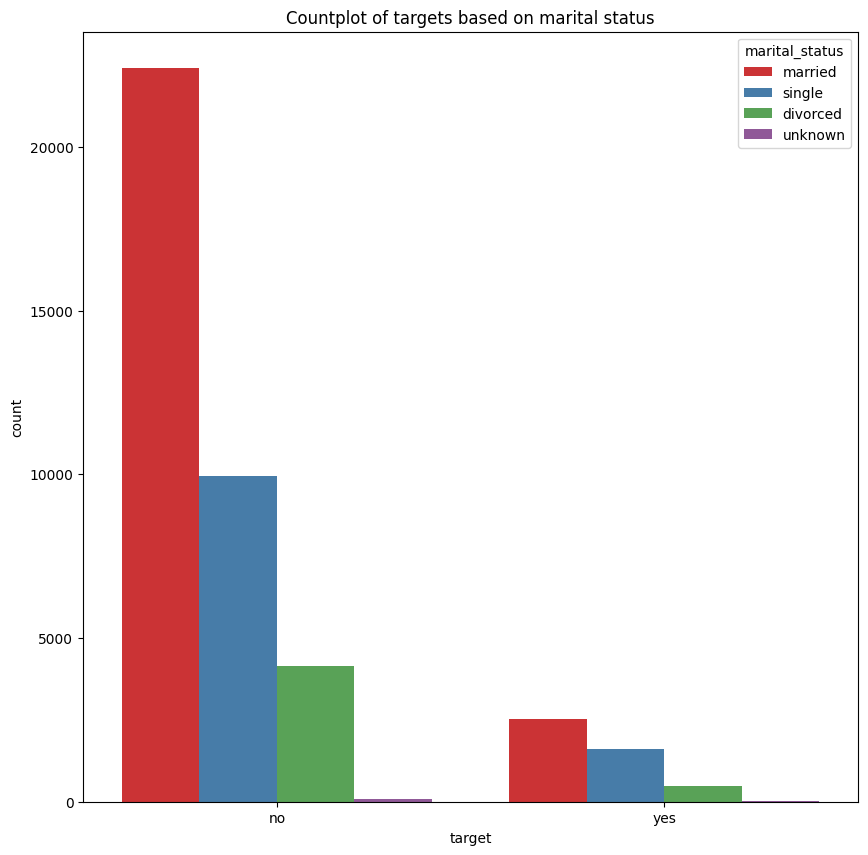

In [170]:
sns.countplot(x='target', hue='marital_status', data=df, palette='Set1').set(title='Countplot of targets based on marital status')

Marital status may have an impact on the likelihood of buying products from the bank. 

/tmp/ipykernel_70393/1512893837.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='age', x='target', data=df, palette='Set1').set(title="Boxplot of age according to target")


[Text(0.5, 1.0, 'Boxplot of age according to target')]

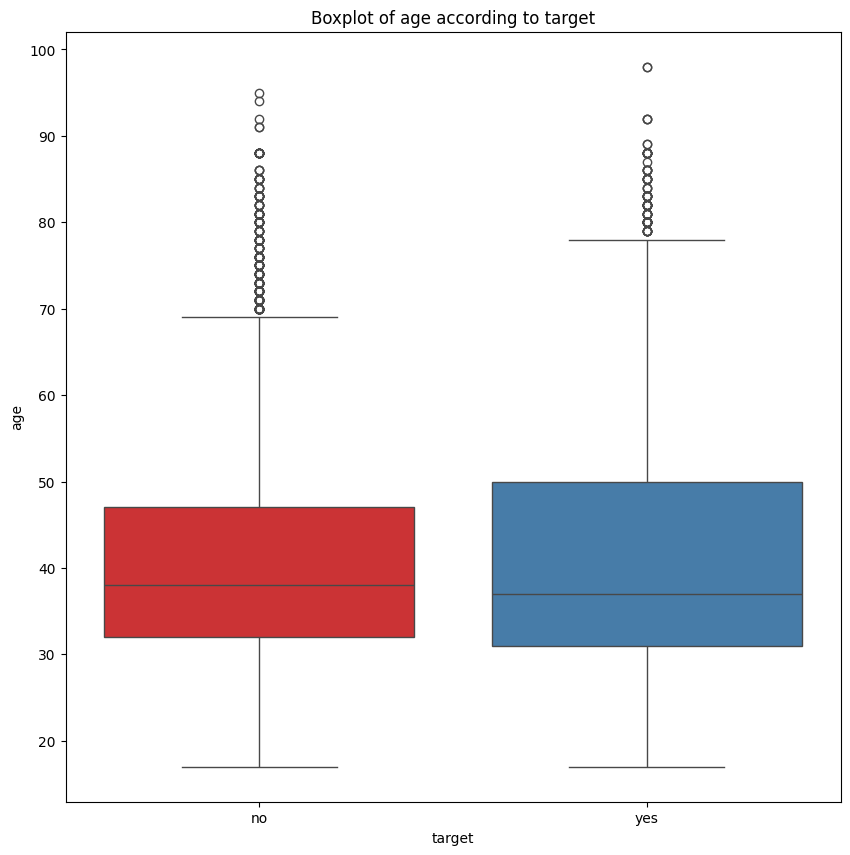

In [171]:
sns.boxplot(y='age', x='target', data=df, palette='Set1').set(title="Boxplot of age according to target")

We can see from the boxplot, that age does not have a significant impact on customer's decision. 

Dummying all categorical variables

In [172]:
df_copy = df.copy()

In [173]:
labels = pd.DataFrame(df_copy['target'])
labels = labels['target'].map({'yes': 1, 'no': 0})
df_copy = df_copy.drop(['target'], axis=1) 

In [174]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df_copy, labels, test_size=0.30, random_state=101)

# Data preprocessing

In [175]:
categorical_variables = df_copy.select_dtypes(include=['O']).columns

We use pipelines to combine the transformation of our variables, both the categorical ones and the continuous one.

In [176]:
# define preprocessing steps for continuous variables
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# define preprocessing steps for categorical variables
categorical_transformer = Pipeline(steps=[
    ('onehot', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))])

# combine preprocessing steps for all variables using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, cont_var),
        ('categorical', categorical_transformer, categorical_variables)])

We perform a gridsearch with cross-validation to find a suitable model.

In [177]:
K = 10
model = Pipeline(steps = [('preprocessor', preprocessor),
                ('model', LogisticRegression(random_state=101))])

param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [100, 1000]
}
model_grid = GridSearchCV(model, param_grid, cv=K, n_jobs=-1)
# Fit the  model
model_grid.fit(Xtrain, Ytrain)



/home/simonl/Desktop/2021AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/simonl/Desktop/2021AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/simonl/Desktop/2021AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/simonl/Desktop/2021AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/simonl/Desktop/2021AI/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/simonl/De

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('continuous',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['age', 'last_contact_duration', 'contacts_per_campaign', 'N_last_days',
       'nb_previous_contact', 'emp_var_rate', 'cons_price_index',
       'cons_conf_index', 'euri_3_month', 'nb_employees'],
      dtype='object')),...
                                                                         Index(['occupation', 'marital_status', 'education', 'has_credit',
       'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day',
       'previous_outcome'],
      dtype='object'))])),
                                       ('model',
                                        LogisticRegression(random_state=101))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__max_iter': [100, 1000],
                         'model__penalty': ['l1'],
                         'model__solver': ['liblinear', 'saga']})

In [178]:
    # test_acc[:,i-1] = boost_grid.cv_results_['mean_test_score']
# Calculate the cross-validation score with 5-fold cross-validation and a confidence interval of 95%
cv_score = cross_val_score(model_grid.best_estimator_, Xtrain, Ytrain, cv=K, scoring='accuracy')
cv_mean = -np.mean(cv_score)
cv_std = np.std(cv_score)
cv_ci = 1.96 * cv_std / np.sqrt(len(cv_score))
print("Best parameters:", model_grid.best_params_)
print("Best score:", model_grid.best_score_)
print(f"CV Score: {cv_mean:.2f} +/- {cv_ci:.2f}")

Best parameters: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'saga'}
Best score: 0.9111723249254441
CV Score: -0.91 +/- 0.00


In [179]:
model_grid.score(Xtest, Ytest)

0.9103342235170349

In [180]:
print(classification_report(y_true=Ytest,y_pred=model_grid.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10978
           1       0.66      0.41      0.50      1379

    accuracy                           0.91     12357
   macro avg       0.79      0.69      0.73     12357
weighted avg       0.90      0.91      0.90     12357



Overall, the model appears to be good at predicting customers who are not likely to buy a subscription, with high precision, recall, and F1-score. However, the model has lower performance to predict if customers are likely to buy a subscription, low precision, recall, and F1-score.

 This suggests that the model may be biased towards predicting customers as not likely to buy a subscription, and may require further tuning or balancing to improve its performance on the positive class.

We start by using Logistic Regression as starting point to establish a baseline before moving to more complex model types.

## Visualization of model performance

To better understand the performance of the model, we investigate each individual feature by looking at their coefficient score:

In [181]:
best_model = model_grid.best_estimator_['model']
coef = best_model.coef_.flatten()

In [182]:
categorical_features = model_grid.best_estimator_.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out()
continuous_features = model_grid.best_estimator_.named_steps['preprocessor'].named_transformers_['continuous'].get_feature_names_out()

In [183]:
len(categorical_features)

52

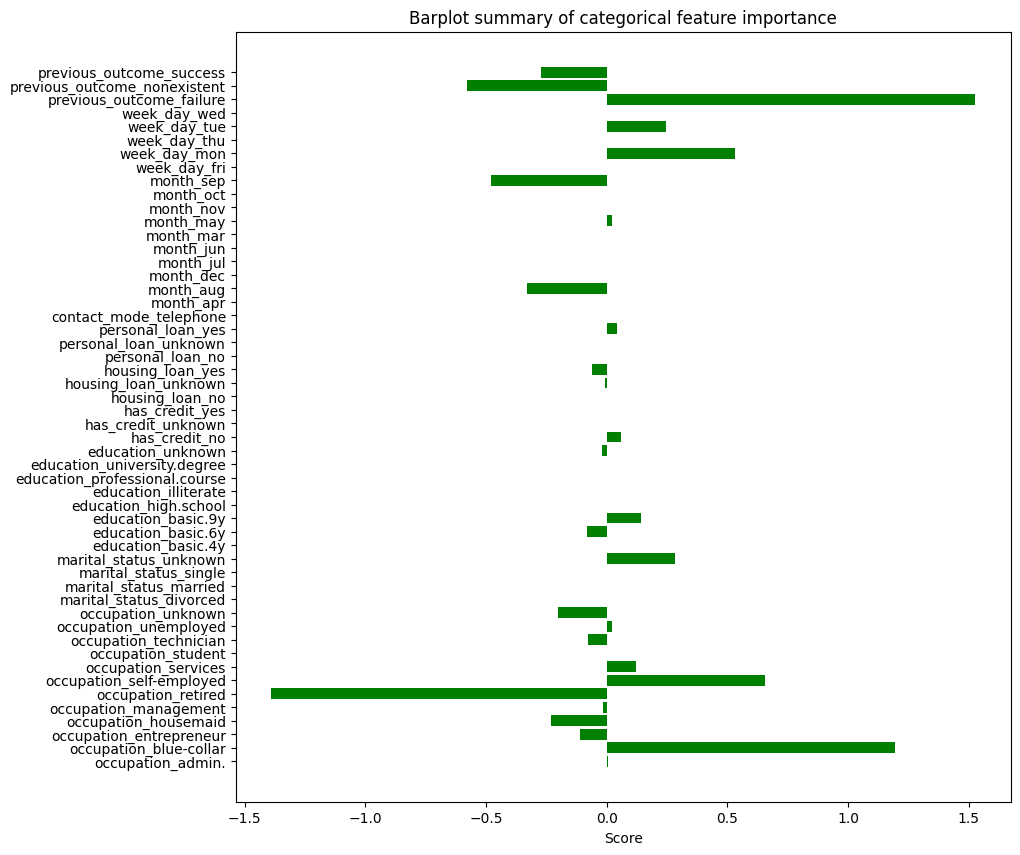

In [184]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.barh(categorical_features, coef[:len(categorical_features)], color='g')
plt.title("Barplot summary of categorical feature importance")
plt.xlabel("Score")
plt.show()

This graph tell us how much importance the model puts into variables. As we can see, it seems like the various occupations of a customer does have quite a significant impact on the model. The same goes for the income. On the other hand, the monthly insight data on a customer does not bring much information. 

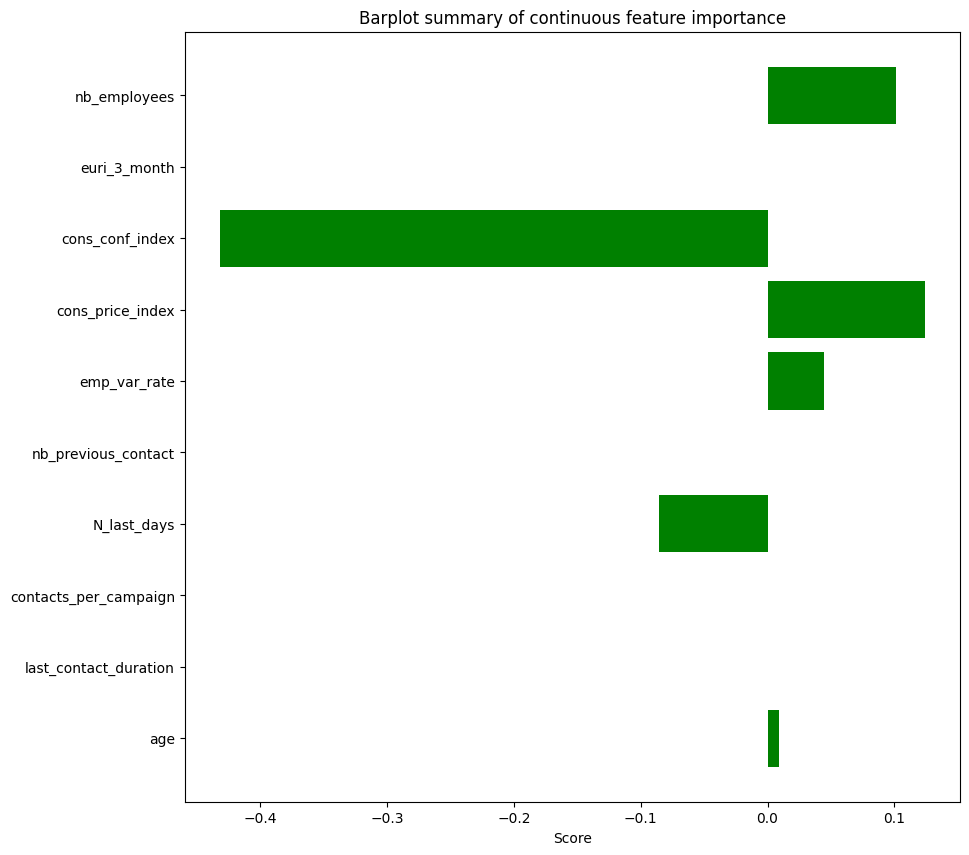

In [185]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.barh(continuous_features, coef[len(categorical_features):], color='g')
plt.title("Barplot summary of continuous feature importance")
plt.xlabel("Score")
plt.show()

A same analysis is made for the continuous variables. The cons_conf_index seems to have much more impact as well as the nb_employees.

In [186]:
roc_auc = sklearn.metrics.roc_auc_score(Ytest, model_grid.predict_proba(Xtest)[:, 1])
fpr, tpr, _ = sklearn.metrics.roc_curve(Ytest, model_grid.predict_proba(Xtest)[:, 1])

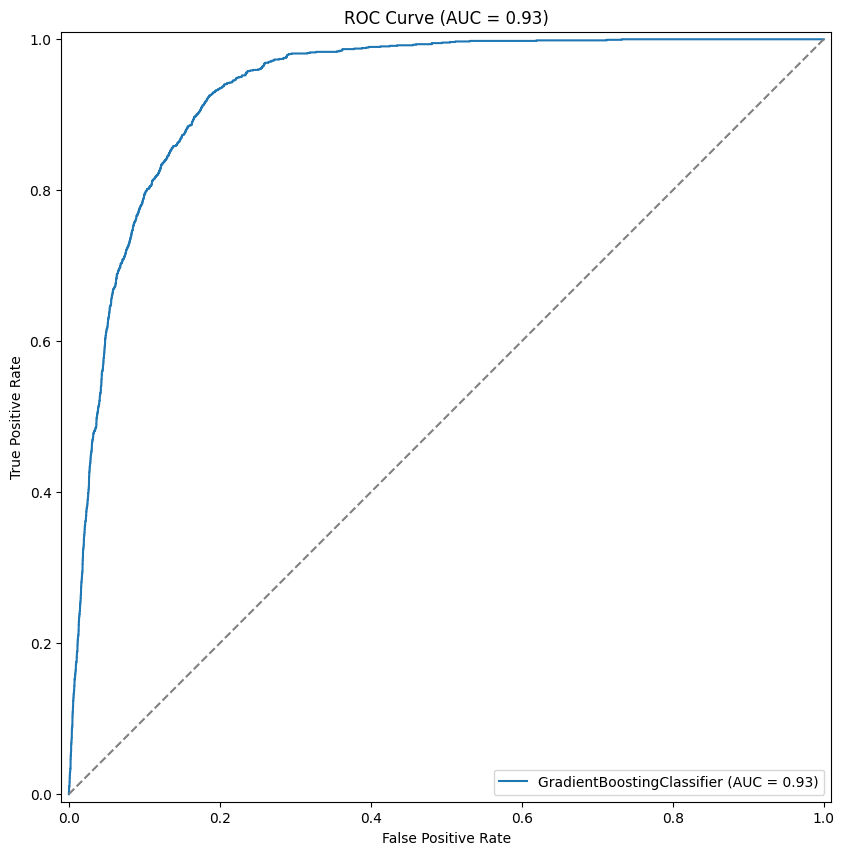

In [187]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="GradientBoostingClassifier")
display.plot()
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='No skill')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()

The AUC of 0.93 indicates that our classifier has a high level of accuracy in distinguishing between positive and negative classes. Based on our context, this is a good sign. Since we can accept to a certain extent to allow false positives. 

## GradientBoosting

We consider a more powerful model called gradient-boosting. It's an ensemble of decision trees. Tree-based models are better than linear models because:
- No need to scale numerical features
- Using an ordinal encoding for the categorical variables is fine even if the encoding results in an arbitrary ordering

In [275]:
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1) #Encodes the categories as integer arrays, denoting the values in a discrete manner.
preprocessor = ColumnTransformer([("categorical", categorical_preprocessor, categorical_variables)], remainder="passthrough")
model = Pipeline(steps=[('preprocessor', preprocessor), ('model', GradientBoostingClassifier(random_state=101))])

In [276]:
K = 10
param_grid = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [100, 200]
}
model_grid = GridSearchCV(model, param_grid, cv=K, n_jobs=-1)
# Fit the  model
model_grid.fit(Xtrain, Ytrain)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['occupation', 'marital_status', 'education', 'has_credit',
       'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day',
       'previous_outcome'],
      dtype='object'))])),
                                       ('model',
                                        GradientBoostingClassifier(random_state=101))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__n_estimators': [100, 200]})

In [277]:
model_grid.score(Xtest, Ytest)

0.917131989965202

In [278]:
print(classification_report(y_true=Ytest,y_pred=model_grid.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10978
           1       0.66      0.54      0.59      1379

    accuracy                           0.92     12357
   macro avg       0.80      0.75      0.77     12357
weighted avg       0.91      0.92      0.91     12357



Much better results than the logistic regression.

In [192]:
feat_importance = model_grid.best_estimator_['model'].feature_importances_

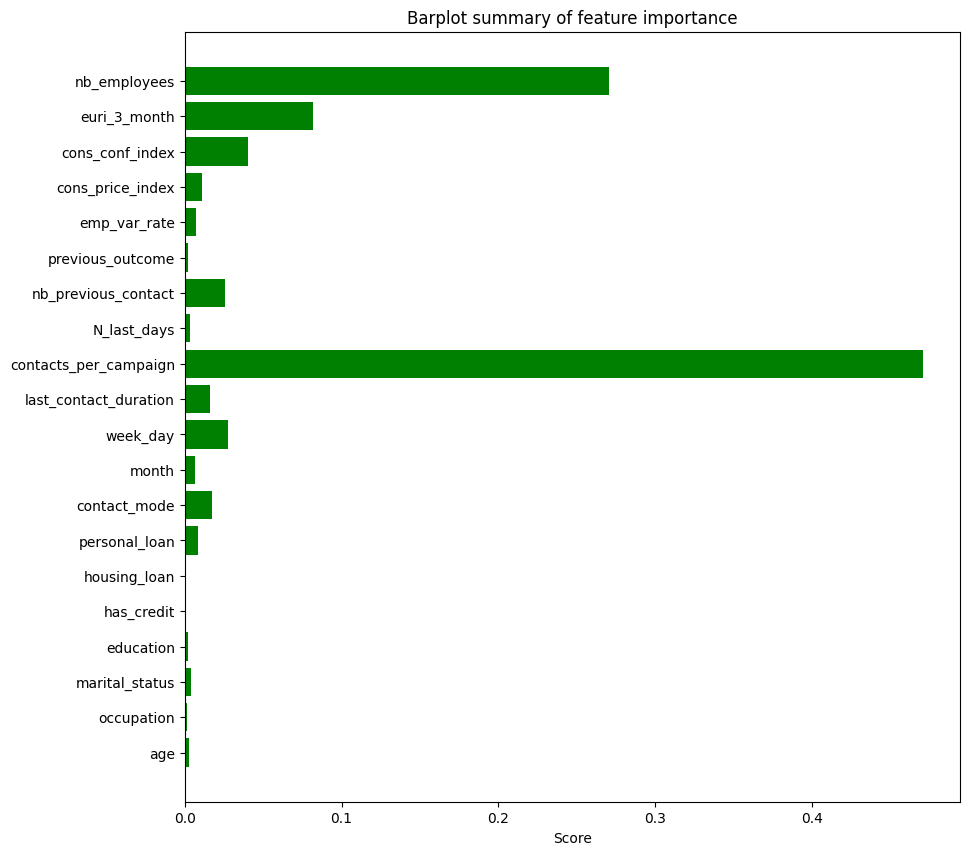

In [193]:
plt.barh(Xtrain.columns, feat_importance, color='g')
plt.title("Barplot summary of feature importance")
plt.xlabel("Score")
plt.show()

Here the gradient boosting put more importance on the contacts_per_campaign, nb_employees and euri_3_months. With more data context, there would be something to interpret here.

In [203]:
roc_auc = sklearn.metrics.roc_auc_score(Ytest, model_grid.predict_proba(Xtest)[:, 1])
fpr, tpr, _ = sklearn.metrics.roc_curve(Ytest, model_grid.predict_proba(Xtest)[:, 1])

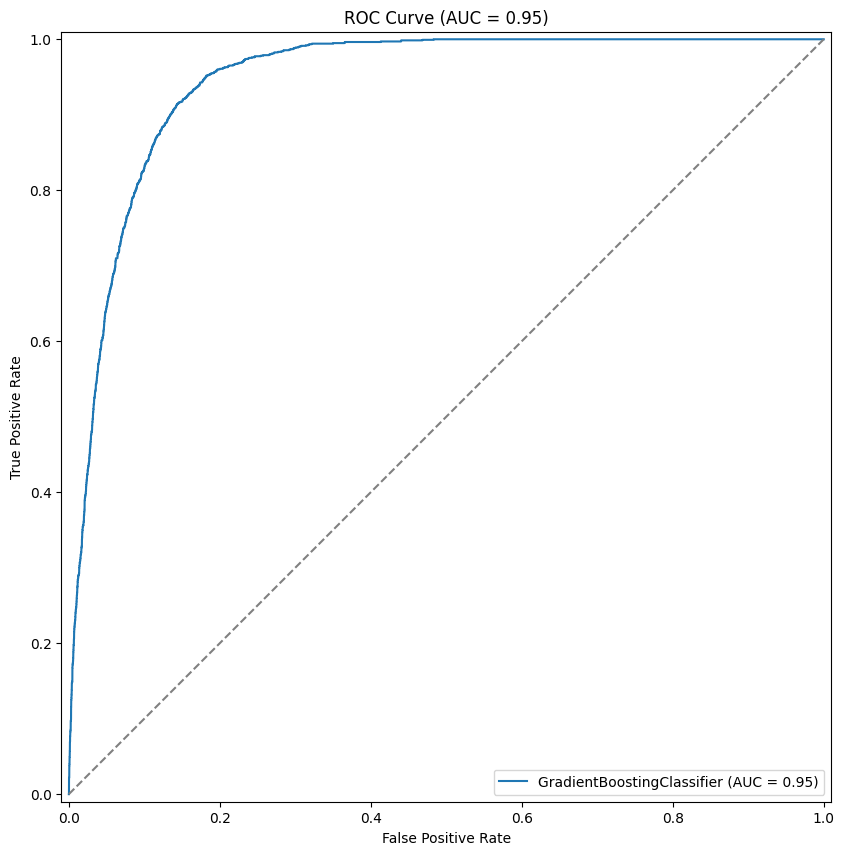

In [195]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="GradientBoostingClassifier")
display.plot()
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='No skill')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')
plt.show()

## Saving model

In [201]:
with open('GradientBoostingClassifier-0-1-0.pkl', 'wb') as f:
    pickle.dump(model_grid.best_estimator_, f)

In [202]:
sklearn.__version__

'1.4.1.post1'

## Further experimentation

In [232]:
from sklearn.decomposition import PCA

In [233]:
pca = PCA()

In [237]:
df_copy_2 = df.copy()

In [238]:
labels = pd.DataFrame(df_copy_2['target'])
labels = labels['target'].map({'yes': 1, 'no': 0})
df_copy_2 = df_copy_2.drop(['target'], axis=1) 

In [239]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df_copy_2, labels, test_size=0.30, random_state=101)

In [240]:
categorical_variables = df_copy_2.select_dtypes(include=['O']).columns
cont_var = df_copy_2.select_dtypes(include=['float64', 'int64']).columns

In [241]:
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1) #Encodes the categories as integer arrays, denoting the values in a discrete manner.
preprocessor = ColumnTransformer([("categorical", categorical_preprocessor, categorical_variables)], remainder="passthrough")
model = Pipeline(steps=[('preprocessor', preprocessor), ('pca', pca), ('model', GradientBoostingClassifier(random_state=101))])

In [258]:
K = 10
param_grid = {
    'model__learning_rate': [0.1],
    'pca__n_components': [1, 3, 5, 10, 20],
    'model__n_estimators': [200]
}
model_grid = GridSearchCV(model, param_grid, cv=K, n_jobs=-1, verbose=3)
# Fit the  model
model_grid.fit(Xtrain, Ytrain)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[CV 1/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.893 total time=   5.0s
[CV 5/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.894 total time=   4.9s
[CV 6/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.890 total time=   4.9s
[CV 7/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.890 total time=   5.4s
[CV 8/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.892 total time=   5.3s
[CV 4/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.892 total time=   5.5s
[CV 3/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.891 total time=   5.9s
[CV 2/10] END model__learning_rate=0.1, model__n_estimators=200, pca__n_components=1;, score=0.898 total time=   6.0s
[CV 10/10] END model__learning_rate=0.1, model__n_estima

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         Index(['occupation', 'marital_status', 'education', 'has_credit',
       'housing_loan', 'personal_loan', 'contact_mode', 'month', 'week_day',
       'previous_outcome'],
      dtype='object'))])),
                                       ('pca', PCA()),
                                       ('model',
                                        GradientBoostingClassifier(random_state=101))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1],
                         'model__n_estimators': [200],
                         'pca__n_components': [1, 3, 5, 10, 20]},
             verbose=3)

In [259]:
model_grid.score(Xtest, Ytest)

0.9137331067411184

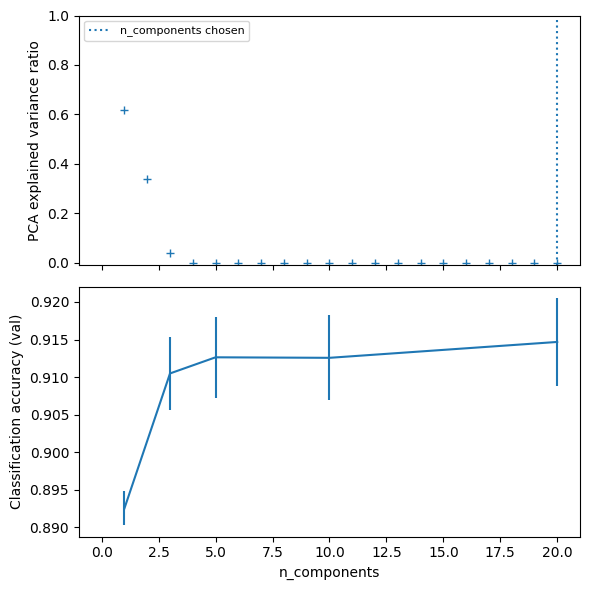

In [260]:
Xtrain_processed = preprocessor.fit_transform(Xtrain)
# Plot the PCA spectrum
pca.fit(Xtrain_processed)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_ylim(-0.01, 1.0)
ax0.axvline(
    model_grid.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=8))

# For each number of components, find the best classifier results
results = pd.DataFrame(model_grid.cv_results_)
components_col = "param_pca__n_components"
best_clfs = results.groupby(components_col)[
    [components_col, "mean_test_score", "std_test_score"]
].apply(lambda g: g.nlargest(1, "mean_test_score"))
ax1.errorbar(
    best_clfs[components_col],
    best_clfs["mean_test_score"],
    yerr=best_clfs["std_test_score"],
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

plt.xlim(-1, 21)

plt.tight_layout()
plt.show()

In [261]:
print(classification_report(y_true=Ytest,y_pred=model_grid.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10978
           1       0.64      0.51      0.57      1379

    accuracy                           0.91     12357
   macro avg       0.79      0.74      0.76     12357
weighted avg       0.91      0.91      0.91     12357



In [262]:
feat_importance = model_grid.best_estimator_['model'].feature_importances_

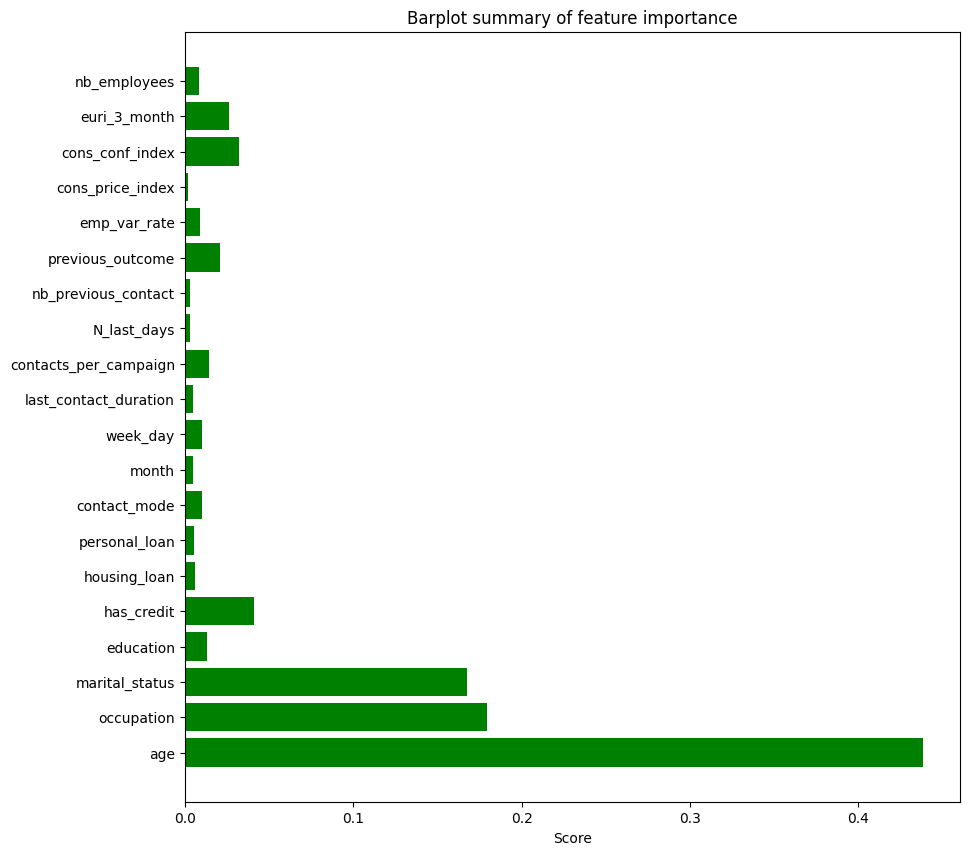

In [263]:
plt.barh(Xtrain.columns, feat_importance, color='g')
plt.title("Barplot summary of feature importance")
plt.xlabel("Score")
plt.show()